[View in Colaboratory](https://colab.research.google.com/github/gauravbansal98/Sentiment-classification-on-news-of-disaster-on-social-media-02-06-2018/blob/master/using_noraml_nn_and_word_embeddings_accuray_around_79.ipynb)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
import random
import time
from collections import Counter
import keras
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

import os
os.chdir('drive/disasters on social media')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
print(stop_words)

In [0]:
import re
import codecs
  

In [19]:
questions = pd.read_csv('socialmedia-disaster-tweets-DFE.csv', encoding = 'latin-1')
questions = questions[['choose_one', 'text']]
questions.head()


,choose_one,text
0,Relevant,Just happened a terrible car crash
1,Relevant,Our Deeds are the Reason of this #earthquake M...
2,Relevant,"Heard about #earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,Forest fire near La Ronge Sask. Canada


In [20]:
questions.tail()


,choose_one,text
10871,Relevant,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872,Relevant,Police investigating after an e-bike collided ...
10873,Relevant,The Latest: More Homes Razed by Northern Calif...
10874,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...
10875,Relevant,#CityofCalgary has activated its Municipal Eme...


In [21]:
def standardize_text(df, text_field):
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  df[text_field] = df[text_field].str.replace(r"http", "")
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
  df[text_field] = df[text_field].str.replace(r"@", "at")
  df[text_field] = df[text_field].str.lower()
  return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,choose_one,text
0,Relevant,just happened a terrible car crash
1,Relevant,our deeds are the reason of this earthquake m...
2,Relevant,"heard about earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,forest fire near la ronge sask canada


In [22]:
questions.groupby('choose_one').count()

,text
choose_one,
Can't Decide,16
Not Relevant,6187
Relevant,4673


In [23]:
def create_lexicon():
  file = pd.read_csv('clean_data.csv', encoding = 'latin-1')
  tweets = file['text']
  lexicon = []
  for line in tweets:
    words = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in words]
    lexicon += words
   
  #lexicon = set(lexicon)
  lexicon_without_stop_words= []
  
  for word in lexicon:
    if word in stop_words:
      continue
    else:
      lexicon_without_stop_words.append(word)
      
  print(len(lexicon_without_stop_words))
  
  final_lexicon= [] 
  
  words = nltk.FreqDist(lexicon_without_stop_words)
  
  for word in words:
    if words[word] > 2 and len(word) > 2:
      final_lexicon.append(word)
   
  return final_lexicon
      
lexicon = create_lexicon()

111553


In [24]:
len_of_lexicon = len(lexicon)
print(len_of_lexicon)

4859


In [0]:
import matplotlib.pyplot as plt

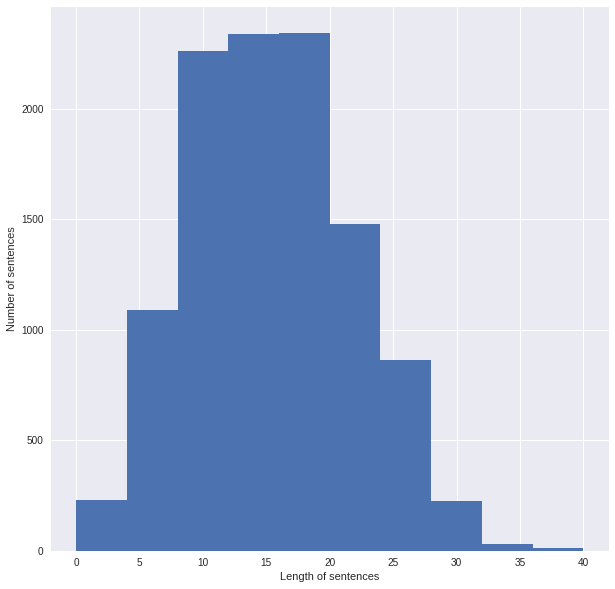

Average length of a sentence: 14.978484737035675


In [26]:
def plot_the_length_of_sentences():
  file = pd.read_csv('clean_data.csv', encoding = 'latin-1')
  tweets = file['text']
  sentences_length = []
  for line in tweets:
    words = word_tokenize(line)
    sentences_length.append(len(words))
    
  fig = plt.figure(figsize = (10, 10))
  plt.xlabel('Length of sentences')
  plt.ylabel('Number of sentences')
  plt.hist(sentences_length, range = (0,40))
  plt.show()
  
  return sentences_length

  
sentences_length = plot_the_length_of_sentences()
print('Average length of a sentence:', sum(sentences_length)/len(questions['text']))

In [0]:
word_embeddings = []
word_embeddings_word = []
i = 0
with open('glove.6B.100d.txt', 'r') as f:
  lines = f.readlines()
  len_ = len(lines)
  for line in lines[:int(.98*len_)]:         #as it crashes when used whole length
    line = line.lower()
    words = word_tokenize(line)
    word_embeddings_word.append(words[0])
    word_embeddings.append(words[1:])
print(word_embeddings)

In [28]:
print(len(word_embeddings_word))
index_of_a_word_in_lexicon_in_word_embeddings = []
value = []
for word in lexicon:
  if word in word_embeddings_word:
    value.append(word)
    index_in_word_embeddings = word_embeddings_word.index(word)
    index_of_a_word_in_lexicon_in_word_embeddings.append(index_in_word_embeddings)
  else:
    index_of_a_word_in_lexicon_in_word_embeddings.append(0)
    

392000


In [0]:
from sklearn.model_selection import train_test_split

clean_questions = pd.read_csv('clean_data.csv', encoding = 'latin-1') 

outputs = []

for output in clean_questions['choose_one']:
  if output == 'Relevant':
    outputs.append(1)
  elif output == 'Not Relevant':
    outputs.append(0)
  else:
    outputs.append(2)
    
clean_questions['choose_one'] = outputs

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["choose_one"].tolist()


X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.1, 
                                                                                random_state=40, shuffle = True)

In [31]:
y_train_dual = []
y_test_dual = []
for i in y_train:
  if i == 1:
    y_train_dual.append([1, 0])
  elif i == 0:
    y_train_dual.append([0, 1])
  else:
    y_train_dual.append([0, 0])
    
for i in y_test:
  if i == 1:
    y_test_dual.append([1, 0])
  elif i == 0:
    y_test_dual.append([0, 1])
  else:
    y_test_dual.append([0, 0])
    
y_train = y_train_dual
y_test = y_test_dual

print(y_train)

[[1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1],

In [32]:
print(X_train)
print(y_train)

['no civilian population ever deserves demolition may we never forget  amp  learn from our mistakes  hiroshima', '  it wouldnt turn into a sandstorm if riot gave a good answer   instead they gave dumb excuses  at least new client is there', 'check these out       nsfw', ' i literally walked out of the concert and screamed my soul has been blessed', "coastal german shepherd rescue oc shared a link  'ecstatic rescued racco      animalrescue", ' its broken its fully exploded ', 'love when drake floods instagram  makes you feel real in tune with everything he did like you was there or sumn ', "time is ripe for yet another banana blight  the banana's appeal is not slipping  but the future of bananas is in  _ ", 'witness video shows car explode behind burning buildings on 2nd st this afternoon  manchester   via ', 'check out my lava lamp dude ???? ', ' sing  tsunami beginners  computer tutorial    everyone wants to learn to build a pc  re ', 'when transgender sam takes runaway lizzie in two 

In [33]:
def convert_to_list(X_train, X_test):
  X_train_list = []
  for line in X_train:
    words = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in words]
    X_train_list.append(words)
    
  X_test_list = []
  for line in X_test:
    words = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in words]
    X_test_list.append(words)
    
  return X_train_list, X_test_list

X_train, X_test = convert_to_list(X_train, X_test)
print(X_train[:10])

[['no', 'civilian', 'population', 'ever', 'deserves', 'demolition', 'may', 'we', 'never', 'forget', 'amp', 'learn', 'from', 'our', 'mistake', 'hiroshima'], ['it', 'wouldnt', 'turn', 'into', 'a', 'sandstorm', 'if', 'riot', 'gave', 'a', 'good', 'answer', 'instead', 'they', 'gave', 'dumb', 'excuse', 'at', 'least', 'new', 'client', 'is', 'there'], ['check', 'these', 'out', 'nsfw'], ['i', 'literally', 'walked', 'out', 'of', 'the', 'concert', 'and', 'screamed', 'my', 'soul', 'ha', 'been', 'blessed'], ['coastal', 'german', 'shepherd', 'rescue', 'oc', 'shared', 'a', 'link', "'ecstatic", 'rescued', 'racco', 'animalrescue'], ['it', 'broken', 'it', 'fully', 'exploded'], ['love', 'when', 'drake', 'flood', 'instagram', 'make', 'you', 'feel', 'real', 'in', 'tune', 'with', 'everything', 'he', 'did', 'like', 'you', 'wa', 'there', 'or', 'sumn'], ['time', 'is', 'ripe', 'for', 'yet', 'another', 'banana', 'blight', 'the', 'banana', "'s", 'appeal', 'is', 'not', 'slipping', 'but', 'the', 'future', 'of', 'ba

In [0]:
# 2 to 95 because there are faults in the embeddings
def convert_to_vector(lines):
  no_of_samples = len(lines)
  features_of_batch = []
  for line in lines:
    features_of_line = np.zeros((1, 93))
    for word in line:
      if word in value:
        index_in_lexicon = lexicon.index(word)
        for i in range(93):
          a = word_embeddings[index_of_a_word_in_lexicon_in_word_embeddings[index_in_lexicon]][i + 2: i + 3]
          #print(float(a[0]))
          features_of_line[0, i:i+1] += float(a[0])
    features_of_batch.append(list(features_of_line))
  features_of_batch = np.array(features_of_batch)
  features_of_batch = np.reshape(features_of_batch, (no_of_samples, 93))
  print(features_of_batch.shape)
    
  return features_of_batch
              
features = convert_to_vector(X_train[:128])
print(features[2])            
              


In [57]:
os.chdir('/content')
!git clone https://github.com/mixuala/colab_utils
import colab_utils.tboard
ROOT = %pwd
print(ROOT)
LOG_DIR = os.path.join(ROOT, 'gaurav')
print(LOG_DIR)
colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

Cloning into 'colab_utils'...
remote: Counting objects: 238, done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 238 (delta 8), reused 14 (delta 4), pack-reused 220
Receiving objects: 100% (238/238), 74.90 KiB | 7.49 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content
/content/gaurav
calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= https://47bea2d4.ngrok.io


'https://47bea2d4.ngrok.io'

In [0]:
batch_size = 64

nodes_l1 = 100
output_nodes = 2

x = tf.placeholder('float', name = 'input_labels')
y = tf.placeholder('float', name = 'output_labels')
keep_prob = tf.placeholder('float', name = 'keep_prob')
learning = tf.placeholder('float', name = 'learning_rate')

hm_epochs = 2

output_layer = {'weights': tf.Variable(tf.random_normal([93, output_nodes], name = 'weights')),
                'biases' : tf.Variable(tf.random_normal([1, output_nodes], name = 'biases'))}

In [0]:
def neural_network_model(x):
  with tf.name_scope('neural network'):
  
    outputs = tf.add(tf.matmul(x, output_layer['weights']), output_layer['biases'])
    #drop_out = tf.nn.dropout(outputs, keep_prob)          #if want to use umcomment this and remove regulizer
    return outputs

In [0]:
saver = tf.train.Saver()

In [0]:
def train_neural_network(x):
  beta = 0.00001
  prediction = neural_network_model(x)
  regularizer = tf.nn.l2_loss(output_layer['weights'])
  with tf.name_scope('cost'):  
  summary = tf.summary.scalar('total_cost_of_batch', cost)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y) + beta*regularizer)
  summary = tf.summary.scalar('total_cost_of_batch', cost)
  
  with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning).minimize(cost)
    
  merged = tf.summary.merge_all() 
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
    train_writer = tf.summary.FileWriter('./gaurav',sess.graph)
    k = 0
    len_of_train_data = len(X_train)
    for epoch in range(hm_epochs):
      epoch_loss = 0
      starting = 0
      end = batch_size
   
      while end <= len_of_train_data:
        epoch_x = X_train[starting:end]
        epoch_y = y_train[starting:end]
        starting = end
        end = end + batch_size
        
        epoch_x = convert_to_vector(epoch_x)
        
        _, c, m = sess.run([optimizer, cost, merged], feed_dict={x: epoch_x, y: epoch_y, keep_prob : 0.7, learning : 18.0/(1000 + 80*epoch)})
        
        epoch_loss += c
        train_writer.add_summary(m, k)
        k += 1
      
      print('loss after ', epoch, 'is', epoch_loss)
      
    saver.save(sess, './model')
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
    epoch_x = X_test
    epoch_x = convert_to_vector(epoch_x)
    
    epoch_y = y_test
    
    print('Accuracy:',accuracy.eval({x:epoch_x, y:epoch_y, keep_prob : 1.0}))
    
train_neural_network(x)

In [56]:
with tf.Session() as sess:
  prediction = neural_network_model(x)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
  sess.run(tf.global_variables_initializer())
  #new_saver = tf.train.import_meta_graph('model.meta')
  print('heelo')
  saver.restore(sess, tf.train.latest_checkpoint('./'))
  print('yes')
  correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
      
  accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
      
  epoch_x = X_test
  epoch_x = convert_to_vector(epoch_x)
      
  epoch_y = y_test
    
  print('Accuracy:',accuracy.eval({x:epoch_x, y:epoch_y, keep_prob : 1.0}))       
  

heelo
INFO:tensorflow:Restoring parameters from ./model
yes
(1088, 93)
Accuracy: 0.7463235
